In [16]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def diag(ax):
    return ax.plot([0, 1], [0, 1], color="grey", linestyle="--", transform=ax.transAxes)

In [2]:
from event2vec_modified.experiment import run_experiment
from event2vec_modified.datasets import GaussMixtureDatasetFactory
from event2vec_modified.model import E2VMLPConfig
from event2vec_modified.prior import DirichletParameterPrior, UncorrelatedJointPrior
from event2vec_modified.training import TrainingConfig
from event2vec_modified.loss import BCELoss, MSELoss

key = jax.random.PRNGKey(42)

gen_param_prior = DirichletParameterPrior(alpha=jnp.array([9.0, 3.0, 3.0]))
train_param_prior = gen_param_prior
data_factory = GaussMixtureDatasetFactory(
    len=200_000,
    param_prior=gen_param_prior,
)
model_config = E2VMLPConfig(
    event_dim=2,
    param_dim=3,
    summary_dim=2,
    hidden_size=4,
    depth=3,
)
train_config = TrainingConfig(
    test_fraction=0.1,
    batch_size=128,
    learning_rate=0.005,
    epochs=200,
    loss_fn=BCELoss(UncorrelatedJointPrior(gen_param_prior)),
)
model, data, loss_train, loss_test = run_experiment(
    data_factory, model_config, train_config, key=key
)


Output()

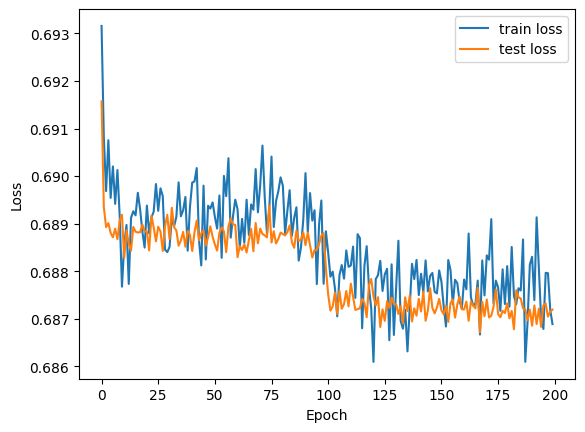

In [3]:
fig, ax = plt.subplots()

ax.plot(loss_train, label="train loss")
ax.plot(loss_test, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

Text(0, 0.5, 'True LLR')

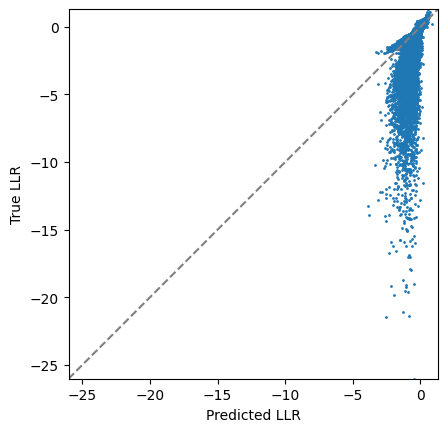

In [5]:
fig, ax = plt.subplots()

param_1 = jnp.broadcast_to(jnp.array([0.9, 0.1, 0.0]), (len(data), 3))

llr_pred = jax.vmap(model.llr_pred)(
    data.observables, data.gen_parameters, param_1
)
llr_true = jnp.log(data.likelihood(param_1)) - jnp.log(
    data.likelihood(data.gen_parameters)
)
amin = min(jnp.min(llr_pred).item(), jnp.min(llr_true).item())
amax = max(jnp.max(llr_pred).item(), jnp.max(llr_true).item())
ax.set_xlim(amin, amax)
ax.set_ylim(amin, amax)
ax.set_aspect("equal")

diag(ax)
ax.scatter(llr_pred, llr_true, s=1)
ax.set_xlabel("Predicted LLR")
ax.set_ylabel("True LLR")

Text(0, 0.5, 'True LLR')

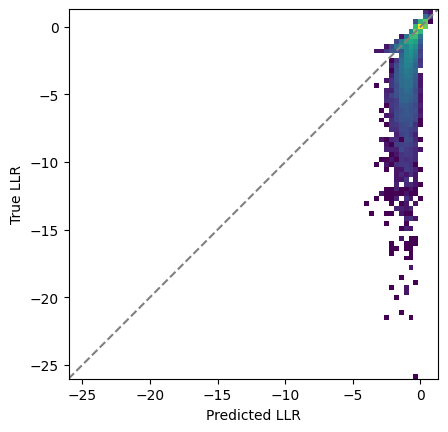

In [18]:
fig, ax = plt.subplots()

param_1 = jnp.broadcast_to(jnp.array([0.9, 0.1, 0.0]), (len(data), 3))

llr_pred = jax.vmap(model.llr_pred)(
    data.observables, data.gen_parameters, param_1
)
llr_true = jnp.log(data.likelihood(param_1)) - jnp.log(
    data.likelihood(data.gen_parameters)
)
amin = min(jnp.min(llr_pred).item(), jnp.min(llr_true).item())
amax = max(jnp.max(llr_pred).item(), jnp.max(llr_true).item())
ax.set_xlim(amin, amax)
ax.set_ylim(amin, amax)
ax.set_aspect("equal")

rang = float(jnp.min(jnp.concatenate([llr_pred, llr_true]))), float(jnp.max(jnp.concatenate([llr_pred, llr_true])))

ax.hist2d(llr_pred, llr_true, bins=75, range=(rang, rang), rasterized=True, norm=LogNorm())
diag(ax)
ax.set_xlabel("Predicted LLR")
ax.set_ylabel("True LLR")

(-4.0, 4.0)

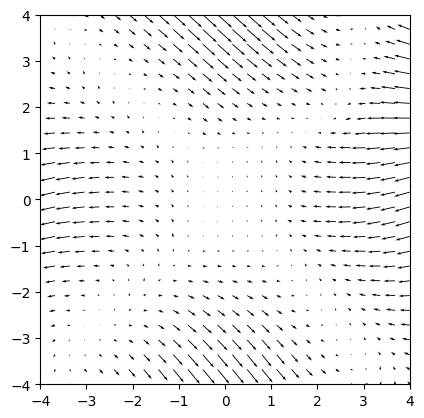

In [20]:
x1 = jnp.linspace(-4, 4, 26)
x2 = jnp.linspace(-4, 4, 26)

x1, x2 = jnp.meshgrid(x1, x2)
x1 = x1.flatten()
x2 = x2.flatten()
x = jnp.stack([x1, x2], axis=-1)

# assert isinstance(model, E2VMLP)  # for type hints
summary = jax.vmap(model.event_summary_model)(x)

fig, ax = plt.subplots()
ax.quiver(x1, x2, summary[:,0], summary[:,1])
ax.set_aspect('equal')

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)